In [48]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import BertTokenizer
from transformers import BertModel, AdamW, get_linear_schedule_with_warmup
import torch.nn as nn
import random

In [49]:
# Load the HC3 dataset
hc3_dataset = load_dataset("Hello-SimpleAI/HC3", "all")  # GPT 3 and human responses
gcs3_dataset = load_dataset(
    "Nitral-AI/Gryphe-Claude_Sonnet-3.5-SlimOrca-140k-ShareGPT"
)  # Claude3.5  responses

In [50]:
print(hc3_dataset)
print(gcs3_dataset)
print("\nchatgpt answer:", hc3_dataset["train"][0]["chatgpt_answers"][0])
print("\nclaude_3.5 answer:", gcs3_dataset["train"][0]["conversations"][2]["value"])

DatasetDict({
    train: Dataset({
        features: ['id', 'question', 'human_answers', 'chatgpt_answers', 'source'],
        num_rows: 24322
    })
})
DatasetDict({
    train: Dataset({
        features: ['conversations'],
        num_rows: 139797
    })
})

chatgpt answer: There are many different best seller lists that are published by various organizations, and the New York Times is just one of them. The New York Times best seller list is a weekly list that ranks the best-selling books in the United States based on sales data from a number of different retailers. The list is published in the New York Times newspaper and is widely considered to be one of the most influential best seller lists in the book industry. 
It's important to note that the New York Times best seller list is not the only best seller list out there, and there are many other lists that rank the top-selling books in different categories or in different countries. So it's possible that a book could be a best sell

In [51]:
# Prepare the dataset
def prepare_hc3_data(dataset, cap=5000):
    texts = []
    labels = []
    human_count = 0
    chatgpt_count = 0
    # Process human responses (label 0)
    for entry in dataset["train"]:
        texts.append(entry["human_answers"][0])  # Take first human answer
        labels.append(0)  # Human = 0
        human_count += 1
        if human_count >= cap:
            break

    # Process ChatGPT responses (label 1)
    for entry in dataset["train"]:
        if entry["chatgpt_answers"]:
            texts.append(entry["chatgpt_answers"][0])  # Take first GPT answer
            labels.append(1)  # GPT3 = 1
            chatgpt_count += 1
        if chatgpt_count >= cap:
            break

    return texts, labels


def prepare_gcs3_data(dataset, cap=5000):
    texts = []
    labels = []

    claude_count = 0

    for entry in dataset["train"]:
        texts.append(entry["conversations"][2]["value"])
        labels.append(2)  # Claude = 2
        claude_count += 1
        if claude_count >= cap:
            break

    return texts, labels


def combine_and_shuffle_data(
    texts1,
    labels1,
    texts2,
    labels2,
):

    combined_texts = texts1 + texts2
    combined_labels = labels1 + labels2

    # Create indices for shuffling
    indices = list(range(len(combined_texts)))

    # Shuffle the indices
    random.shuffle(indices)

    # Use the shuffled indices to create new shuffled lists
    shuffled_texts = [combined_texts[i] for i in indices]
    shuffled_labels = [combined_labels[i] for i in indices]

    return shuffled_texts, shuffled_labels

In [52]:
# Prepare data
CAP = 3000  # Number of samples to use from each dataset class
print("CAP:", CAP)

hc3_texts, hc3_labels = prepare_hc3_data(hc3_dataset, CAP)
print("\n---Human and ChatGPT samples---")
print(f"Total texts: {len(hc3_texts)}")
print(f"Total labels: {len(hc3_labels)}")
print(f"Label distribution: {pd.Series(hc3_labels).value_counts()}")

gcs3_texts, gcs3_labels = prepare_gcs3_data(gcs3_dataset, CAP)

print("\n---Claude 3.5 samples---")
print(f"Total texts: {len(gcs3_texts)}")
print(f"Total labels: {len(gcs3_labels)}")
print(f"Label distribution: {pd.Series(gcs3_labels).value_counts()}")

CAP: 3000

---Human and ChatGPT samples---
Total texts: 6000
Total labels: 6000
Label distribution: 0    3000
1    3000
Name: count, dtype: int64

---Claude 3.5 samples---
Total texts: 3000
Total labels: 3000
Label distribution: 2    3000
Name: count, dtype: int64


In [53]:
print(hc3_texts[0:5])
print(hc3_labels[0:5])
print(gcs3_texts[0:5])
print(gcs3_labels[0:5])


print("Combining and Shuffling data...")
texts, labels = combine_and_shuffle_data(hc3_texts, hc3_labels, gcs3_texts, gcs3_labels)

# random.shuffle(texts)
# random.shuffle(labels)

print(f"Randomly shuffled texts: {texts[0:5]}")
print(f"Randomly shuffled labels: {labels[0:50]}")
print(f"Label distribution: {pd.Series(labels).value_counts()}")

['Basically there are many categories of " Best Seller " . Replace " Best Seller " by something like " Oscars " and every " best seller " book is basically an " oscar - winning " book . May not have won the " Best film " , but even if you won the best director or best script , you \'re still an " oscar - winning " film . Same thing for best sellers . Also , IIRC the rankings change every week or something like that . Some you might not be best seller one week , but you may be the next week . I guess even if you do n\'t stay there for long , you still achieved the status . Hence , # 1 best seller .', 'salt is good for not dying in car crashes and car crashes are worse for cars then salt . Some places use other things , but salt is really cheap compared to most alternatives , although sand is pretty good .', "The way it works is that old TV stations got a certain amount of bandwidth to replace their old analog TV stations . However , HD takes up more bandwidth then SD - so the stations c

In [54]:
# Generate a random index within the bounds of the array
random_index = random.randint(0, len(texts) - 1)  # Use -1 to stay within array bounds

print(
    "\n",
    "Label:",
    labels[random_index],
    "\n",
    "Label meaning:",
    ["Human", "GPT-3", "Claude"][labels[random_index]],
    "\n",
    "Random text and label:\n",
    texts[random_index],
)


 Label: 1 
 Label meaning: GPT-3 
 Random text and label:
 Crayons are a popular art supply for children because they are easy to hold and use. They are made of wax, so they are soft and smooth, and they can be used to color on a variety of surfaces. They are also relatively inexpensive and widely available, making them a good choice for parents and teachers. 
Colored pencils are also a popular art supply, but they are generally considered to be more suitable for older children and adults. Colored pencils are made of pigments mixed with a binder, and they require a bit more skill and control to use than crayons. Colored pencils are often used for more detailed and precise coloring and drawing, whereas crayons are more suitable for broader strokes and filling in large areas. 
That being said, there is no rule that says only small children can use crayons, and there is no reason why children of any age can't use colored pencils if they are interested in doing so. Many children do enjoy 

In [55]:
# Create a custom Dataset class
class HC3_GCS3_Dataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text, truncation=True, padding="max_length", max_length=self.max_length, return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].flatten().long(),
            "attention_mask": encoding["attention_mask"].flatten().long(),
            "labels": torch.tensor(label, dtype=torch.long),
        }

In [56]:
# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [57]:
# Split data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42, stratify=labels
)

# Create datasets
train_dataset = HC3_GCS3_Dataset(train_texts, train_labels, tokenizer)
val_dataset = HC3_GCS3_Dataset(val_texts, val_labels, tokenizer)

# Create data loaders
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [58]:
print("Train Samples: ", len(train_dataset))
print("Val Samples: ", len(val_dataset))

Train Samples:  7200
Val Samples:  1800


In [60]:
from transformers import BertModel, BertTokenizer
import torch.nn as nn


class LLMDetector(nn.Module):
    def __init__(self, num_classes, model_name="bert-base-uncased"):
        super().__init__()
        self.bert = BertModel.from_pretrained(model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_classes)
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled = outputs.pooler_output
        pooled = self.dropout(pooled)
        return self.classifier(pooled)

In [61]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda


In [62]:
num_classes = 3
model = LLMDetector(num_classes)  # human, gpt3, claude
model.to(device)

LLMDetector(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [63]:
# DEBUG

# Print shapes for debugging
for batch in train_loader:
    print(f"Input IDs shape: {batch['input_ids'].shape}")
    print(f"Attention mask shape: {batch['attention_mask'].shape}")
    print(f"Labels shape: {batch['labels'].shape}")
    print(f"Labels unique values: {torch.unique(batch['labels'])}")
    break

# Check if your labels are within the expected range
print(f"Number of classes in model: {num_classes}")

# Check CUDA memory usage
if torch.cuda.is_available():
    print(f"CUDA Memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"CUDA Memory reserved: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

# Try running with smaller batch size or on CPU if CUDA memory is the issue
if (
    torch.cuda.is_available()
    and torch.cuda.memory_allocated() / torch.cuda.get_device_properties(0).total_memory > 0.8
):
    print("CUDA memory usage high, consider reducing batch size")

Input IDs shape: torch.Size([16, 512])
Attention mask shape: torch.Size([16, 512])
Labels shape: torch.Size([16])
Labels unique values: tensor([0, 1, 2])
Number of classes in model: 3
CUDA Memory allocated: 2.65 GB
CUDA Memory reserved: 6.69 GB


/home/b450-plus/snap/code/181/.local/share/virtualenvs/DMI_FYP_dj_primary-backend-cvNQsyiC/lib/python3.12/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/3: 100%|██████████| 450/450 [07:38<00:00,  1.02s/it, loss=0.0016]


Epoch 1/3
Train Loss: 0.2176, Train Accuracy: 0.9250
Val Loss: 0.0640, Val Accuracy: 0.9856

Unique classes in validation labels: [0 1 2]
Unique classes in model predictions: [0 1 2]

Validation Classification Report:
              precision    recall  f1-score   support

       Human       0.99      0.98      0.99       600
       GPT-3       0.97      1.00      0.99       600
      Claude       0.99      0.98      0.98       600

    accuracy                           0.99      1800
   macro avg       0.99      0.99      0.99      1800
weighted avg       0.99      0.99      0.99      1800



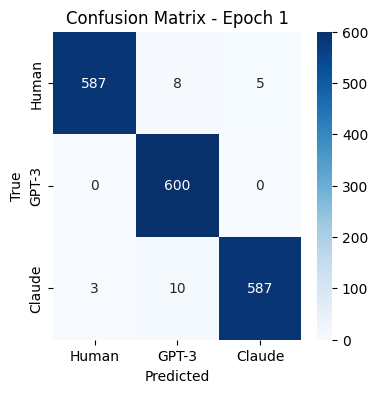


Confusion Matrix:
[[587   8   5]
 [  0 600   0]
 [  3  10 587]]

Class distribution in validation set:
Human: 600 samples
GPT-3: 600 samples
Claude: 600 samples
Saved best model!


Epoch 2/3: 100%|██████████| 450/450 [07:35<00:00,  1.01s/it, loss=0.0005]


Epoch 2/3
Train Loss: 0.0118, Train Accuracy: 0.9971
Val Loss: 0.0991, Val Accuracy: 0.9822

Unique classes in validation labels: [0 1 2]
Unique classes in model predictions: [0 1 2]

Validation Classification Report:
              precision    recall  f1-score   support

       Human       1.00      0.97      0.98       600
       GPT-3       0.96      1.00      0.98       600
      Claude       0.99      0.97      0.98       600

    accuracy                           0.98      1800
   macro avg       0.98      0.98      0.98      1800
weighted avg       0.98      0.98      0.98      1800



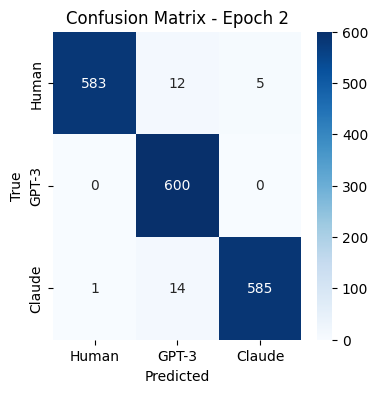


Confusion Matrix:
[[583  12   5]
 [  0 600   0]
 [  1  14 585]]

Class distribution in validation set:
Human: 600 samples
GPT-3: 600 samples
Claude: 600 samples


Epoch 3/3: 100%|██████████| 450/450 [07:33<00:00,  1.01s/it, loss=0.0004]


Epoch 3/3
Train Loss: 0.0015, Train Accuracy: 0.9997
Val Loss: 0.0797, Val Accuracy: 0.9856

Unique classes in validation labels: [0 1 2]
Unique classes in model predictions: [0 1 2]

Validation Classification Report:
              precision    recall  f1-score   support

       Human       1.00      0.97      0.99       600
       GPT-3       0.97      1.00      0.98       600
      Claude       0.99      0.98      0.99       600

    accuracy                           0.99      1800
   macro avg       0.99      0.99      0.99      1800
weighted avg       0.99      0.99      0.99      1800



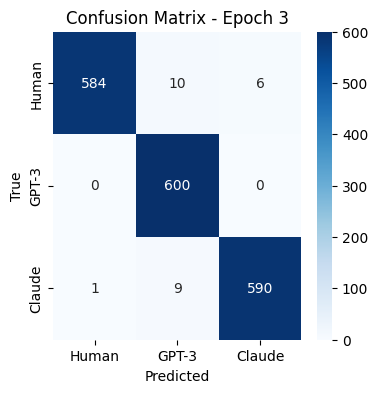


Confusion Matrix:
[[584  10   6]
 [  0 600   0]
 [  1   9 590]]

Class distribution in validation set:
Human: 600 samples
GPT-3: 600 samples
Claude: 600 samples


In [64]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Training parameters
epochs = 3
best_accuracy = 0

# Set up optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=100, num_training_steps=len(train_loader) * epochs
)

model_path = f"/home/b450-plus/DMI_FYP_dj_primary-backend/DMI_FYP_dj_primary-backend/DMI_backend/ML_Models/AIGT_bert_epoch{epochs}.ipynb.pth"

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    train_preds = []
    train_labels_list = []

    # Training
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

    for batch in progress_bar:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()
        train_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
        train_labels_list.extend(labels.cpu().numpy())

        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    # Validation
    model.eval()
    val_loss = 0
    val_preds = []
    val_labels_list = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            val_labels_list.extend(labels.cpu().numpy())

    # Calculate metrics
    train_accuracy = accuracy_score(train_labels_list, train_preds)
    val_accuracy = accuracy_score(val_labels_list, val_preds)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Print classification report for validation data
    unique_labels = np.unique(val_labels_list)
    target_names = ["Human", "GPT-3", "Claude"]  # Make sure these match your label indices (0, 1, 2)

    print("\nUnique classes in validation labels:", np.unique(val_labels_list))
    print("Unique classes in model predictions:", np.unique(val_preds))

    print("\nValidation Classification Report:")
    print(
        classification_report(
            val_labels_list,
            val_preds,
            target_names=[target_names[i] for i in unique_labels],
            zero_division=0,  # Explicitly handle division by zero
        )
    )

    # Create and display confusion matrix
    cm = confusion_matrix(val_labels_list, val_preds)
    plt.figure(figsize=(4, 4))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=[target_names[i] for i in unique_labels],
        yticklabels=[target_names[i] for i in unique_labels],
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - Epoch {epoch+1}")
    plt.show()

    # Also print the raw confusion matrix for reference
    print("\nConfusion Matrix:")
    print(cm)

    # Count class distribution in the validation set
    print("\nClass distribution in validation set:")
    for i in unique_labels:
        print(f"{target_names[i]}: {val_labels_list.count(i)} samples")

    # Save best model
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), model_path)
        print("Saved best model!")

In [65]:
# Load the best model for inference
model_path = f"/home/b450-plus/DMI_FYP_dj_primary-backend/DMI_FYP_dj_primary-backend/DMI_backend/ML_Models/AIGT_bert_epoch{3}.ipynb.pth"

model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

/tmp/ipykernel_160923/3665789510.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


LLMDetector(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_a

In [66]:
print(model.classifier.out_features)

3


In [ ]:
def predict_text_source(text):
    encoding = tokenizer(
        text, truncation=True, padding="max_length", max_length=512, return_tensors="pt"
    )
    input_ids = encoding["input_ids"].to(device).long()
    attention_mask = encoding["attention_mask"].to(device).long()

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        logits = outputs if isinstance(outputs, torch.Tensor) else outputs[0]
        probs = torch.softmax(logits, dim=1)
        print("Logits shape:", logits.shape)  # Debug print to see output dimensions
        predicted_class = torch.argmax(probs, dim=1).item()

    # Adjust the label pool based on the number of classes
    # If logits.shape[1] == 2, use two-class pool; if 3, use three-class pool.
    if logits.shape[1] == 3:
        labels_pool = ["Human", "GPT-3", "Claude"]
    else:
        labels_pool = ["Human", "GPT-3"]

    probabilities = probs[0].cpu().numpy()

    return {
        "prediction": labels_pool[predicted_class],
        "confidence": {labels_pool[i]: float(probabilities[i]) for i in range(len(labels_pool))},
    }


def predict_text_source_with_highlights(text: str, window_size: int = 100, stride: int = 50) -> dict:
    """
    Analyzes text for AI-generated content using sliding windows.
    Words with averaged AI probability (i.e. non-'Human') above 0.4 are surrounded by {} braces.
    Returns the overall prediction, confidence scores, and highlighted text versions.
    """
    # Overall full-text prediction
    full_prediction = predict_text_source(text)

    # Split text into words and create overlapping chunks
    words = text.split()
    chunks = []
    chunk_indices = []
    current_chunk = []
    current_length = 0
    start_idx = 0

    for i, word in enumerate(words):
        current_chunk.append(word)
        current_length += len(word) + 1  # account for space
        if current_length >= window_size:
            chunks.append(" ".join(current_chunk))
            chunk_indices.append((start_idx, i))
            # Slide window by removing words until the remaining length is <= stride
            while current_length > stride and current_chunk:
                removed_word = current_chunk.pop(0)
                current_length -= len(removed_word) + 1
                start_idx += 1

    # Include any remaining words as a chunk
    if current_chunk:
        chunks.append(" ".join(current_chunk))
        chunk_indices.append((start_idx, len(words) - 1))

    # Analyze each chunk for prediction confidence
    chunk_predictions = []
    for chunk in chunks:
        chunk_pred = predict_text_source(chunk)
        chunk_predictions.append(chunk_pred)

    # Compute AI probability for each word (sum all probabilities except 'Human')
    word_scores = np.zeros(len(words))
    word_counts = np.zeros(len(words))
    for (s_idx, e_idx), pred in zip(chunk_indices, chunk_predictions):
        ai_prob = sum(prob for label, prob in pred["confidence"].items() if label != "Human")
        word_scores[s_idx : e_idx + 1] += ai_prob
        word_counts[s_idx : e_idx + 1] += 1

    # Average the scores where available
    word_scores = np.divide(word_scores, word_counts, where=word_counts != 0)
    print("Word Scores:", word_scores.tolist())
    # Create terminal highlighted text by wrapping words with {} if their score > 0.4
    highlighted_text = []
    for word, score in zip(words, word_scores):
        if score > 0.025:
            highlighted_text.append("{" + word + "}")
        else:
            highlighted_text.append(word)

    # Create an HTML version with similar highlighting
    html_text = text
    for word, score in reversed(list(zip(words, word_scores))):
        if score > 0.4:
            html_text = html_text.replace(word, "{" + word + "}", 1)

    return {
        "prediction": full_prediction["prediction"],
        "confidence": full_prediction["confidence"],
        "highlighted_text": " ".join(highlighted_text),
        "html_text": html_text,
        "word_scores": word_scores.tolist(),
    }

In [84]:
# Example usage
sample_text = """
Hey man wassup
"""

# random_idx = random.randint(0, len(texts))
# sample_text = texts[random_idx]
# actual_label = labels[random_idx]
# print(
#     "Atucal Label:",
#     actual_label,
#     "\nLabel meaning:",
#     ["Human", "GPT-3", "Claude"][actual_label],
# )

print(
    "Text :\n",
    sample_text,
)
result = predict_text_source(sample_text)
print(f"Prediction: {result['prediction']}")
print("Confidence scores:")
for source, score in result["confidence"].items():
    print(f"- {source}: {score:.4f}")

Text :
 
Hey man wassup

Logits shape: torch.Size([1, 3])
Prediction: Human
Confidence scores:
- Human: 0.9965
- GPT-3: 0.0027
- Claude: 0.0008


In [85]:
sample_text = """
The early morning fog rolled across the meadow, shrouding the landscape in a soft, ethereal glow. Birds began their chorus as the first rays of sunlight pierced through the mist, illuminating dewdrops that clung to blades of grass like tiny crystals. In the distance, the silhouette of pine trees stood tall against the brightening sky, their outlines gradually becoming more defined as the day awakened.
\nThe old stone cottage at the edge of the field remained silent, its windows dark, chimney cold. A weathered path led from its wooden door across the field, winding its way toward the village beyond the hills. Time seemed suspended in this moment between night and day, a peaceful transition marked only by nature's subtle shifts.
"""
result = predict_text_source_with_highlights(sample_text)
print(f"\nOverall Prediction: {result['prediction']}")
print(f"Confidence Scores: {result['confidence']}")
print("\nHighlighted Text Analysis:")
print(result["highlighted_text"])

Logits shape: torch.Size([1, 3])
Logits shape: torch.Size([1, 3])
Logits shape: torch.Size([1, 3])
Logits shape: torch.Size([1, 3])
Logits shape: torch.Size([1, 3])
Logits shape: torch.Size([1, 3])
Logits shape: torch.Size([1, 3])
Logits shape: torch.Size([1, 3])
Logits shape: torch.Size([1, 3])
Logits shape: torch.Size([1, 3])
Logits shape: torch.Size([1, 3])
Logits shape: torch.Size([1, 3])
Logits shape: torch.Size([1, 3])
Word Scores: [0.020012064836919308, 0.020012064836919308, 0.020012064836919308, 0.020012064836919308, 0.020012064836919308, 0.020012064836919308, 0.020012064836919308, 0.020012064836919308, 0.020012064836919308, 0.025014207931235433, 0.025014207931235433, 0.025014207931235433, 0.025014207931235433, 0.025014207931235433, 0.025014207931235433, 0.025014207931235433, 0.025014207931235433, 0.030016351025551558, 0.030016351025551558, 0.01695317792473361, 0.01695317792473361, 0.01695317792473361, 0.01695317792473361, 0.01695317792473361, 0.01695317792473361, 0.01695317792